Typical Milankovitch‐scale variations and today’s (J2000.0) values are roughly:

    Eccentricity e

        Varies between about 0.005 and 0.058 over the 100 kyr and 400 kyr cycles.

        Present‐day (J2000.0):
        e0≈0.0167086
        

    Obliquity ε (tilt of the spin axis)

        Oscillates between ∼22.1∘ and 24.5 with a ∼41 kyr period.

        In radians: 0.386–0.428,rad.

        Present‐day:
        ε0≈23.4393∘≈0.4091  rad
        
    Longitude of perihelion ϖ

        Circulates through 0∘–360∘ with an average period of ∼112 kyr.

        Present‐day (J2000.0):
        ϖ0≈102.937∘≈1.7966 rad
    
        In many paleoclimate studies one actually uses the “precession parameter”
        esin⁡(ϖ+ωpre)
        (where ωpre≈180 for NH summer) to capture the insolation effect.

These ranges fully capture the Milanković modulation of Earth’s orbit (eccentricity), tilt (obliquity) and precession (longitude of perihelion).

See Laskar, J., Fienga, A., Gastineau, M., Manche, H.: 2011, La2010: A new orbital solution for the long term motion of the Earth.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def kepler_equation(E, M, e):
    return E - e * np.sin(E) - M

def kepler_solve(M, e, tol=1e-8, max_iter=100):
    """
    Solve Kepler's equation M = E - e*sin(E) for E using Newton-Raphson.
    M, e can be scalars or numpy arrays.
    """
    E = M.copy()
    for _ in range(max_iter):
        f = kepler_equation(E, M, e)
        fp = 1 - e * np.cos(E)
        dE = -f / fp
        E = E + dE
        if np.all(np.abs(dE) < tol):
            break
    return E

def daily_mean_insolation(phi, t, e, eps, varpi, tau, 
                          S0=1368.0, a=1.0):
    """
    Compute daily-mean TOA insolation Q(phi, t).

    phi: 1D array of latitudes (rad)
    t, e, eps, varpi, tau: 1D arrays of same length (time)
    Returns Q of shape (len(phi), len(t))
    """
    # Ensure numpy arrays
    phi = np.atleast_1d(phi)
    t = np.atleast_1d(t)
    e = np.atleast_1d(e)
    eps = np.atleast_1d(eps)
    varpi = np.atleast_1d(varpi)
    tau = np.atleast_1d(tau)

    # Solve Kepler's equation for E
    n = 2 * np.pi  # 1/year
    M = n * (t - tau)
    E = kepler_solve(M, e)  # use previously defined kepler_solve

    # True anomaly and orbital radius
    f = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2),
                       np.sqrt(1 - e) * np.cos(E / 2))
    r = a * (1 - e**2) / (1 + e * np.cos(f))

    # Solar position
    lambda_s = f + varpi
    delta = np.arcsin(np.sin(eps) * np.sin(lambda_s))

    # Broadcast for lat x time grid
    phi2 = phi[:, None]     # shape (n_phi, 1)
    delta2 = delta[None, :] # shape (1, n_t)
    # Compute sunset hour angle H0
    cosH0 = -np.tan(phi2) * np.tan(delta2)
    cosH0 = np.clip(cosH0, -1.0, 1.0)  # avoid domain errors
    H0 = np.arccos(cosH0)
    # Polar night/day handling
    mask = (np.abs(phi2) + np.abs(delta2)) > np.pi/2
    H0[mask] = 0.0

    # Insolation terms
    sinphi = np.sin(phi2)
    cosphi = np.cos(phi2)
    sindelta = np.sin(delta2)
    cosdelta = np.cos(delta2)
    term1 = H0 * sinphi * sindelta
    term2 = cosphi * cosdelta * np.sin(H0)

    # Expand r to match grid
    r2 = r[None, :]
    Q = (S0 / np.pi) * (a / r2)**2 * (term1 + term2)

    return Q


def estimate_orbital_elements(t_kyr):
    """
    Estimate orbital elements as simple sinusoids.

    Parameters
    ----------
    t_kyr : array_like
        Time in kiloyears (kyr).

    Returns
    -------
    e : ndarray
        Approximate eccentricity.
    eps : ndarray
        Approximate obliquity (radians).
    varpi : ndarray
        Approximate longitude of perihelion (radians).
    """
    t = np.asarray(t_kyr)

    # Eccentricity (e)
    e_min, e_max = 0.005, 0.058
    e_mean = 0.5 * (e_max + e_min)
    e_amp  = 0.5 * (e_max - e_min)
    e_period = 0.5 * (100 + 400)  # mean of 100 kyr & 400 kyr = 250 kyr
    e = e_mean + e_amp * np.sin(2 * np.pi * t / e_period)

    # Obliquity (ε)
    eps_min_deg, eps_max_deg = 22.1, 24.5
    eps_mean_deg = 0.5 * (eps_max_deg + eps_min_deg)
    eps_amp_deg  = 0.5 * (eps_max_deg - eps_min_deg)
    eps_period = 41.0  # kyr
    eps = np.deg2rad(eps_mean_deg + eps_amp_deg * np.sin(2 * np.pi * t / eps_period))

    # Longitude of perihelion (ϖ)
    varpi_period = 0.5 * (19.0 + 23.0)  # mean of 19 kyr & 23 kyr = 21 kyr
    varpi = np.deg2rad(180.0 + 180.0 * np.sin(2 * np.pi * t / varpi_period))

    return e, eps, varpi


In [17]:
phi = np.linspace(-np.pi/2, np.pi/2, 100)      # latitudes
tau = 0.0                                      # perihelion passage at t=0
t = np.linspace(0, 1000, 1000)  # kyr
e, eps, varpi = estimate_orbital_elements(t)
Q = daily_mean_insolation(phi, t, e, eps, varpi, tau)

(0.0, 1000.0)

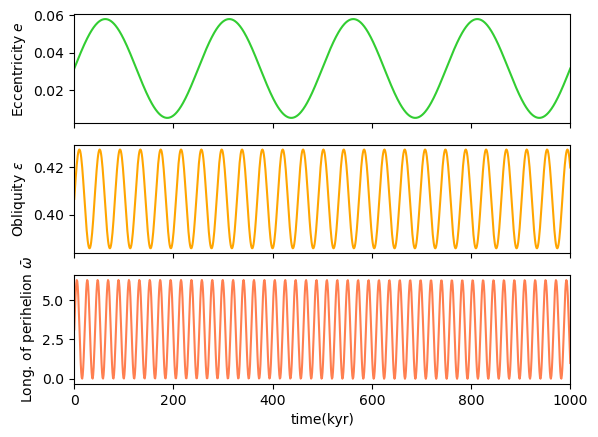

In [18]:
fig, (ax,ax2,ax3) = plt.subplots(3,1,sharex=True)
ax.plot(t,e, color='limegreen')
ax2.plot(t,eps,color='orange')
ax3.plot(t,varpi, color='coral')
ax.set_ylabel('Eccentricity $e$')
ax2.set_ylabel(r'Obliquity $\epsilon$')
ax3.set_ylabel(r'Long. of perihelion $\bar{\omega}$')
ax3.set_xlabel('time(kyr)')
ax3.set_xlim(0,1000)

Text(0.5, 1.0, 'Insolation assuming sinusoidal eccentricity, obliquity and longitude of perhelion')

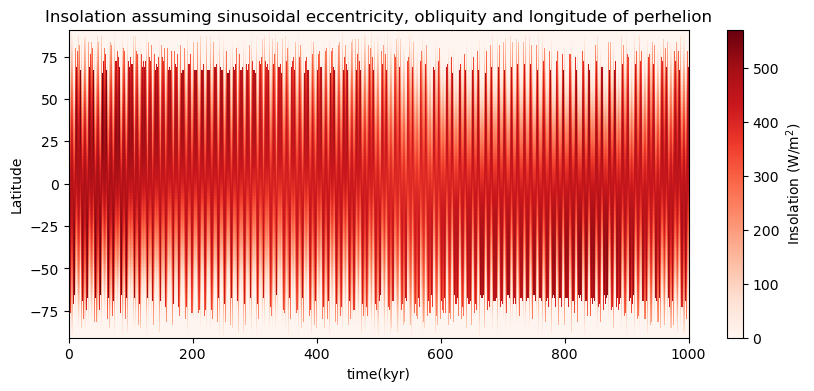

In [19]:
fig, (ax) = plt.subplots(1,1, figsize=(10,4))
pc = ax.pcolormesh(t,phi*180/np.pi,Q, cmap='Reds')
plt.colorbar(pc, label='Insolation (W/m$^2$)')
ax.set_ylabel(r'Latitude')
ax.set_xlabel('time(kyr)')
ax.set_xlim(0,1000)
ax.set_title('Insolation assuming sinusoidal eccentricity, obliquity and longitude of perhelion')

Text(0.5, 1.0, 'Insolation assuming sinusoidal eccentricity, obliquity and longitude of perhelion')

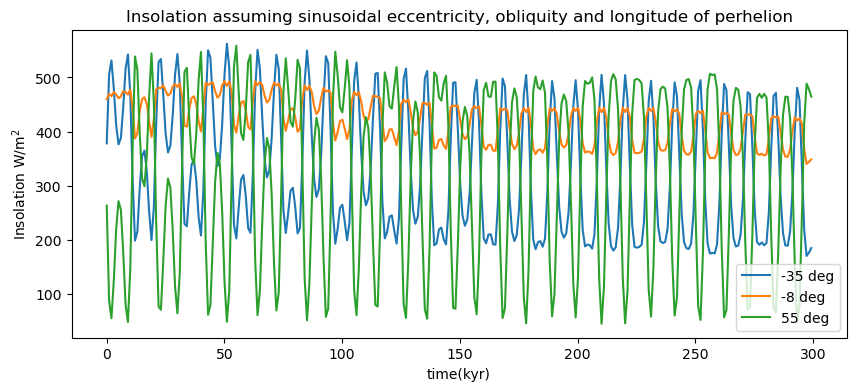

In [20]:
fig, (ax) = plt.subplots(1,1, figsize=(10,4))

# Select some latitudes
lat_ind = [30,45, 80]
for ilat in lat_ind:
    pc = ax.plot(t[:300],Q[ilat,:300], label=f'{phi[ilat]*180/np.pi:.0f} deg')
    
ax.set_ylabel(r'Insolation W/m$^2$')
ax.set_xlabel('time(kyr)')
ax.legend()
ax.set_title('Insolation assuming sinusoidal eccentricity, obliquity and longitude of perhelion')

In [41]:
Qmean=np.nanmean(Q[10:-10], axis=0)

In [42]:
T_ncep =np.array(np.loadtxt('T_zonalmean_NCEP.dat'))


In [43]:
np.shape(Qmean)

(1000,)

In [44]:
np.savetxt('insolation.dat', Qmean)

In [45]:
np.shape(Qmean)

(1000,)